In [1]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import scipy.stats as ss
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

# Кейс - Приложение доставки

Вы работаете аналитиком в сервисе доставки продуктов. В приложении была внедрена интеллектуальная система рекомендаций, которая должна помочь пользователям быстрее находить нужные товары и улучшить их взаимодействие с платформой.\
Чтобы оценить эффективность нововведения, был проведен A/B-тест. В первой группе пользователи получили доступ к новой системе рекомендаций, а во второй остались с прежней версией приложения без рекомендаций.\
Ваша задача — определить, принесло ли это изменение пользу бизнесу и клиентам. Для этого необходимо выбрать ключевые метрики, отражающие качество сервиса, и провести статистическое сравнение результатов между двумя группами.\
Финальный вывод вашей аналитики — обоснованное решение о том, стоит ли запускать новую систему рекомендаций для всех пользователей.

In [2]:
# Загружаем данные
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')
users = pd.read_csv('ab_users_data.csv')

Посмотрим в каком виде представлены данные

In [3]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [4]:
products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [5]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


И информацию о них, чтобы проверить типы данных и наличие пропусков

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


In [7]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


Нули отсутствуют, а вот временные данные имеют тип обжект, но пока не уверен, что они нам пригодятся

В дф users в столбике action пока увидели лишь созданные заказы. А какие еще есть статусы?

In [9]:
users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

Есть только созданные и отмененные заказы. Хочу перепроверить идею о том, что если заказ создан и отменен, он будет появляться дважды в дф, а если не отменен, то один раз

In [10]:
# Отфильтровываем отменненные заказы 

users.query('action == "cancel_order"').head()

,user_id,order_id,action,time,date,group
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0
39,993,1296,cancel_order,2022-08-26 00:44:18.150475,2022-08-26,0
47,995,1298,cancel_order,2022-08-26 00:49:51.514240,2022-08-26,0
54,1002,1308,cancel_order,2022-08-26 00:58:01.924112,2022-08-26,1
60,1008,1315,cancel_order,2022-08-26 01:06:11.292953,2022-08-26,0


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [11]:
# Смотрим любой отмененный заказ

users.query('order_id == 1258')

,user_id,order_id,action,time,date,group
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0


Действительно он оказывается в данных дважды: на этапе создания, а затем отмены \
Созданный и не отмененный заказ будет в данных 1 раз?

In [12]:
# Проверяем
users.query('order_id == 1256')

,user_id,order_id,action,time,date,group
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1


Действительно все так

# Выбор метрики

1. Основной вариант оценки эффективности, который здесь приходит в голову - это средний чек заказа покупателей, так как у нас есть данные с покупками и цены на каждый товар (однако в данных о заказах не указано количество товара. В реальности я бы уточнил этот вопрос у коллег, готовивших данные, но в данном случае примем по умолчанию, что каждый товар заказывался по разу, а в случае покупки двух штук он был бы указан дважды)
2. Прокси-метрикой для среднего чека (особенно если в действительности мы не можем посчитать его из данных, так как все же не очень понятно количество единиц каждого товара в заказах) может быть среднее количество наименований товаров, которое приобреталось в каждом заказе, так как интуитивно кажется, что более удобная система рекомендаций должна позволять набрать большое количество товаров в корзину
3. Еще одним показателем того, что система рекомендаций работет может быть большее количество заказов у каждого пользователя, так как имея более удобный интерфейс и тратя на покупки меньше времени, покупатели будут чаще возвращаться в приложение для следующего заказа (Кажется, это даже главный показатель для проверки, пользователи в среднем могут совершать такие же покупки по стоимости, но делать их в нашем приложении чаще после введения новых рекомендаций)


# Подготовка данных и визуализация

Начать хочется с конца, так как вытащить количество заказов по пользователям и посмотреть, что с ними, проще всего

Также удалим из датафрэйма отмененные заказы, так как нас инетерсует только исполненные

In [13]:
# Создаем столбик указывающий на отменнные заказы

cancelations = users.duplicated(subset=['order_id'], keep=False).rename('canceled')
users = pd.concat([users,cancelations],axis=1)
users.head()

,user_id,order_id,action,time,date,group,canceled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,False
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,False
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,False
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,True
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,False


In [14]:
# Оставляем только подтвержденные заказы

users_confirmed = users.query('canceled == False')
users_confirmed.head()

,user_id,order_id,action,time,date,group,canceled
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,False
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,False
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,False
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,False
5,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,False


Посмотрим на описательные статистики количества заказов пользователей по двум группам

In [15]:
# Также посомтрим на распределение пользователей по группам

users_confirmed.groupby(['group'], as_index=False).agg({'user_id' : 'nunique'})

,group,user_id
0,0,512
1,1,501


Пользователи распределены примерно поровну

#### Контрольная

In [16]:
users_confirmed.query('group == 0').groupby('user_id', as_index=False).agg({'order_id' : 'count'}).order_id.describe()

count    512.000000
mean       2.982422
std        1.886631
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       13.000000
Name: order_id, dtype: float64

#### Тестовая

In [17]:
users_confirmed.query('group == 1').groupby('user_id', as_index=False).agg({'order_id' : 'count'}).order_id.describe()

count    501.000000
mean       4.754491
std        2.138599
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       12.000000
Name: order_id, dtype: float64

У контрольной группы среднее значение покупок - 2.98 шт., а у тестовой - 4.75 шт.

Посмотрим, как это выглядит на графиках

# Графики распределения количества заказов у пользователей 

### Контрольная группа

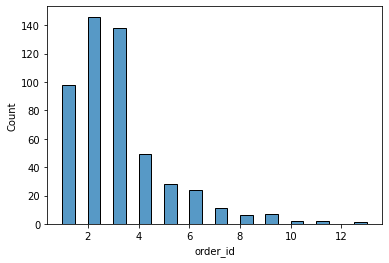

In [18]:
sns.histplot(data=users_confirmed.query('group == 0').groupby('user_id', as_index=False).agg({'order_id' : 'count'}), x="order_id")

### Тестовая группа

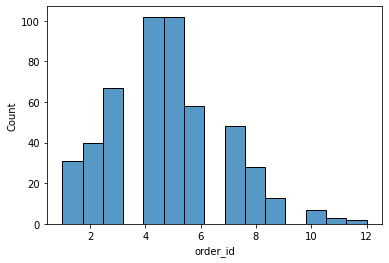

In [19]:
sns.histplot(data=users_confirmed.query('group == 1').groupby('user_id', as_index=False).agg({'order_id' : 'count'}), x="order_id")

На графиках мы тожем видим, что в тестовой группе в целом значения повыше, но еще не факт, что эти отличия являются статистически значимыми
Также мы видим, что наши распределения имеют скошенный хвост и вряд ли похожи на нормальные

In [20]:
# Сохраним данные по количеству покупок в отдельные датафрэймы 

ctrl_orders = users_confirmed.query('group == 0')\
                             .groupby('user_id', as_index=False)\
                             .agg({'order_id' : 'count'})\
                             .rename(columns={'order_id' : 'cnt'})
test_orders = users_confirmed.query('group == 1')\
                             .groupby('user_id', as_index=False)\
                             .agg({'order_id' : 'count'})\
                             .rename(columns={'order_id' : 'cnt'})

# Выбор теста для 3-ей метрики

В данном случае наша метрика непрерывная, а значит мы можем воспользоваться Т-тестом, если распределение признаков нормальное, либо критерием Манна-Уитни (либо Bootstrap), если это не так

По графикам очевидно, что наши данные не пройдут проверку на нормальность распределения, но подтвердим это статистически

In [21]:
pg.normality(ctrl_orders.cnt, method='normaltest')

,W,pval,normal
cnt,178.266627,1.949368e-39,False


In [22]:
pg.normality(test_orders.cnt, method='normaltest')

,W,pval,normal
cnt,17.210719,0.000183,False


В обеих выборках мы отвергаем нулевую гипотезу о нормальности распределения количества просмотренных анкет, так как p-value ниже порога 0.05

Выборки досточно большие, чтобы воспользоваться Т-тестом, но сравнение медиан учитывая скошенность данных, подойдет лучше

В данном случае лучше всего для проверки нашей гипотезы о том, что пользователи из экспериментальной группы делают больше заказов, подойдет Bootstrap, так как распределения скошенные и лучше будет сравнить медианные значения, а не средние

# Расчет результатов для 3-ей метрики

Собираем внутри бутстрапа разницу медиан между двумя группами по этому показателю и сохраняем эти различия

Далее проверям доверительный интервал квантилей и смотрим будет ли он включать в себя 0.

Не знаю корретно ли тут описывать гипотезы в рамках нулевой и альтернативной, но если да, то запись может быть такой:
- $H_0$: предполагает, что медианы равны (в таком случае разница доверительных интервалов будет включать в себя ноль)
- $H_1$: отвергает нулевую гипотезу о равенстве медиан (доверительный интервал не включает в себя ноль)


In [23]:
# Собираем разницу медиан

median_diff = []

for i in range(10000):
    sample_data_control = ctrl_orders.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.cnt.median()
    
    
    sample_data_exp = test_orders.sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.cnt.median()
    
    sample_median_diff = sample_median_exp - sample_median_control
    median_diff.append(sample_median_diff)

In [24]:
# Верхняя граница квантиля для 95% доверительного интервала

pd.Series(median_diff).quantile(0.975)

3.0

In [25]:
# Нижняя граница квантиля для 95% доверительного интервала

pd.Series(median_diff).quantile(0.025)

1.0

По результатам теста разница медиан получилась в доверительном интервале от 1 до 3 в пользу тестовой группы. Это означает, что мы статистически подтвердили, что в тестовой группе пользователи чаще совершают покупки на эту величину за время проведения теста

Теперь перейдем к анализу среднего чека в покупках и количества товаров

# Подготовка данных для анализа 1 и 2 метрик

In [26]:
# Вспомним как выглядят данные о заказах с товарами

orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


ID товаров записаны в очень неудобной форме через запятую, надо разложить их по отдельным столбцам, чтобы подтянуть цену каждого товара и сложить эти цены для каждого заказа. Приступим

In [27]:
# Создадим датафрйем с разделенными покупками и переименуем колонки

products_in_orders = orders.product_ids.str[1:-1].str.split(', ', expand=True)
products_in_orders.columns=['pr1','pr2','pr3', 'pr4', 'pr5', 'pr6', 'pr7', 'pr8']
products_in_orders.head()

,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8
0,75,22,53,84,None,None,None,None
1,56,76,39,None,None,None,None,None
2,76,34,41,38,None,None,None,None
3,74,6,None,None,None,None,None,None
4,20,45,67,26,None,None,None,None


In [28]:
# Изменяем тип данных в колонках на числовой,
# Чтобы затем смерджить этот дф с ценами 
# Из дф с продуктами

for label, content in products_in_orders.iteritems():
    products_in_orders[label] = pd.to_numeric(products_in_orders[label], downcast="integer")

In [29]:
# Мерджим в цикле по каждому столбцу стоимость продукта из этого столбца
# И сразу переименовываем столбцы

for label, content in products_in_orders.iteritems():
    products_in_orders = products_in_orders.merge(products[['product_id', 'price']], left_on=label, right_on='product_id', how='left')
    name = label + '_price'
    products_in_orders = products_in_orders.rename(columns={'price' : name})
    products_in_orders = products_in_orders.drop(columns = ['product_id'],axis = 1)

In [30]:
# Проверяем результат

products_in_orders.head()

,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr1_price,pr2_price,pr3_price,pr4_price,pr5_price,pr6_price,pr7_price,pr8_price
0,75,22.0,53.0,84.0,NaN,NaN,NaN,NaN,120.0,120.0,78.3,90.4,NaN,NaN,NaN,NaN
1,56,76.0,39.0,NaN,NaN,NaN,NaN,NaN,150.0,55.5,45.0,NaN,NaN,NaN,NaN,NaN
2,76,34.0,41.0,38.0,NaN,NaN,NaN,NaN,55.5,98.0,80.4,76.3,NaN,NaN,NaN,NaN
3,74,6.0,NaN,NaN,NaN,NaN,NaN,NaN,60.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
4,20,45.0,67.0,26.0,NaN,NaN,NaN,NaN,50.0,78.0,30.0,70.0,NaN,NaN,NaN,NaN


In [31]:
# Заменим пропущенные значения на нули, коими они и являются

products_in_orders = products_in_orders.fillna(0)

In [32]:
# Сложим значения по строкам для определения общей суммы

products_in_orders['price'] = products_in_orders['pr1_price'] + \
                              products_in_orders['pr2_price'] + \
                              products_in_orders['pr3_price'] + \
                              products_in_orders['pr4_price'] + \
                              products_in_orders['pr5_price'] + \
                              products_in_orders['pr6_price'] + \
                              products_in_orders['pr7_price'] + \
                              products_in_orders['pr8_price']

In [33]:
products_in_orders.head()

,pr1,pr2,pr3,pr4,pr5,pr6,pr7,pr8,pr1_price,pr2_price,pr3_price,pr4_price,pr5_price,pr6_price,pr7_price,pr8_price,price
0,75,22.0,53.0,84.0,0.0,0.0,0.0,0.0,120.0,120.0,78.3,90.4,0.0,0.0,0.0,0.0,408.7
1,56,76.0,39.0,0.0,0.0,0.0,0.0,0.0,150.0,55.5,45.0,0.0,0.0,0.0,0.0,0.0,250.5
2,76,34.0,41.0,38.0,0.0,0.0,0.0,0.0,55.5,98.0,80.4,76.3,0.0,0.0,0.0,0.0,310.2
3,74,6.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0
4,20,45.0,67.0,26.0,0.0,0.0,0.0,0.0,50.0,78.0,30.0,70.0,0.0,0.0,0.0,0.0,228.0


Стоимости каждого заказа мы определили, теперь соберем количество наименований товара в каждой покупке

In [34]:
# Собираем количество покупок
len_products = []
for it_id in orders.product_ids.str[1:-1].str.split(', '):
    len_products.append(len(it_id))
len_products = pd.Series(len_products).rename('quantity')
len_products.head()

0    4
1    3
2    4
3    2
4    4
Name: quantity, dtype: int64

In [35]:
# Мерджим стоимости и количество наименований к нашему изначальному дф с заказами
orders_prices = pd.concat([orders,products_in_orders['price']],axis=1)
orders_prices = pd.concat([orders_prices,len_products],axis=1)
orders_prices.head()

,order_id,creation_time,product_ids,price,quantity
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}",408.7,4
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}",250.5,3
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}",310.2,4
3,1258,2022-08-26 00:02:56.000000,"{74, 6}",85.0,2
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}",228.0,4


Мы собрали необходимые нам данные, теперь можно замерджить этот дф с дф users, где также представлены наши заказы, но с фильтрацией отменных и разделением на экспериментальные группы

In [36]:
# Мерджим нужные колонки с основным датафрйемом

users_confirmed = users_confirmed.merge(orders_prices[['order_id', 'price', 'quantity']], on='order_id', how='left')
users_confirmed.head()

,user_id,order_id,action,time,date,group,canceled,price,quantity
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,False,408.7,4
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,False,250.5,3
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,False,310.2,4
3,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,False,228.0,4
4,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,False,430.7,4


# Визуализация

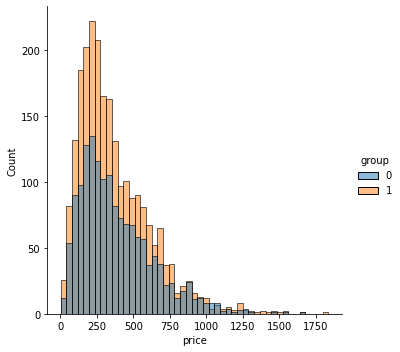

In [37]:
sns.displot(data=users_confirmed, x="price", hue="group")

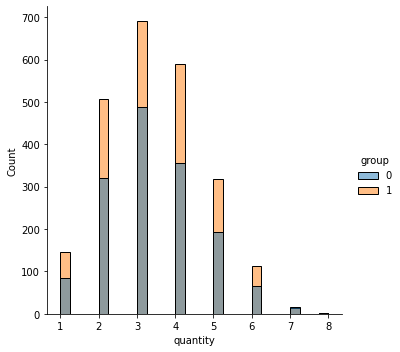

In [38]:
sns.displot(data=users_confirmed, x="quantity", hue="group")

По графикам кажется, что различий в группах нет, но првоерим это статистически

# Выбор теста

Распределения наших переменных являются скошенными и в данном случае мы можем использовать bootstrap для сравнения медион и посмотреть 0,025 и 0,975 квантили на предмет наличия в них нуля. В случае если ноль будет включен в 95% доверительный интервал, то мы принимаем нулевую гипотезу о равенстве медиа в случае же если нет, то мы можем принять альтернавтивную гипотезу

### Сравнение медиан по среднему чеку

In [39]:
median_diff = []

for i in range(10000):
    sample_data_control = users_confirmed.query('group == 0').sample(frac=1, replace=True)
    sample_median_control = sample_data_control.price.median()
    
    
    sample_data_exp = users_confirmed.query('group == 1').sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.price.median()
    
    sample_median_diff = sample_median_exp - sample_median_control
    median_diff.append(sample_median_diff)




In [40]:
pd.Series(median_diff).quantile(0.975)

0.0

In [41]:
pd.Series(median_diff).quantile(0.025)

-36.799999999999955

Ноль вошел в самый край доверительного интервала, при этом стоит отметить, что остальные значения доверительного интервала находятся в отрицательной зоне, что говорит о том, что в тестовой группе средний чек даже ниже

Посмотрим распредлеление медиан на графике

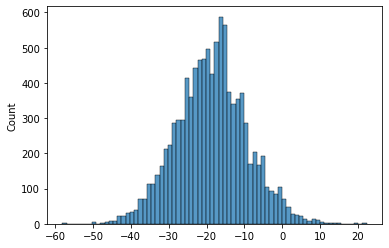

In [42]:
sns.histplot(median_diff)

### Сравнение медиан по количеству товаров

In [43]:
median_diff = []

for i in range(10000):
    sample_data_control = users_confirmed.query('group == 0').sample(frac=1, replace=True)
    sample_median_control = sample_data_control.quantity.median()
    
    
    sample_data_exp = users_confirmed.query('group == 1').sample(frac=1, replace=True)
    sample_median_exp = sample_data_exp.quantity.median()
    
    sample_median_diff = sample_median_exp - sample_median_control
    median_diff.append(sample_median_diff)


In [44]:
pd.Series(median_diff).quantile(0.975)

0.0

In [45]:
pd.Series(median_diff).quantile(0.025)

0.0

Весь доверительный интервал находится в нуле, различий между группами нет

# Выводы

1. В тестовой группе пользователи совершили больше покупок в среднем на 1-3 штуку
2. По среднему чеку и количеству покупаемых товаров в каждой покупке значимых раздичий в группах нет. При этом средний чек находится близ статистически значимых различий, но в пользу контрольной группы
3. Несмотря на сомнительные данные по среднему чеку, люди чаще совершают покупки с новой системой рекомендации, кажется, что есть смысл запускать ее на всех пользователей